# Credit Card Fraud Detection Project

This project implements both unsupervised and supervised machine learning techniques to detect credit card fraud. I've used the Kaggle credit card fraud dataset which contains transactions made by credit cards in September 2013 by European cardholders.

## Project Structure:
1. Data Loading and Exploration
2. Data Preprocessing
3. Unsupervised Learning Approaches:
   - Isolation Forest
   - Mahalanobis Distance
   - k-Nearest Neighbors Distance
4. Supervised Learning Approaches:
   - Random Forest
   - Logistic Regression
   - Decision Tree
   - Support Vector Machine
5. Model Benchmarking and Comparison
6. Conclusions


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, average_precision_score, 
                             precision_recall_curve, roc_curve, 
                             accuracy_score, f1_score, precision_score, recall_score)
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2
import time
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)


## 1. Data Loading and Exploration

In [33]:
df = pd.read_csv("E:/Semester 5/creditcard.csv/creditcard.csv")

#Basic info
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Class distribution
print("\nClass distribution:")
print(df['Class'].value_counts(normalize=True))

Dataset shape: (284807, 31)

First 5 rows:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0



Missing values per column:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Class distribution:
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


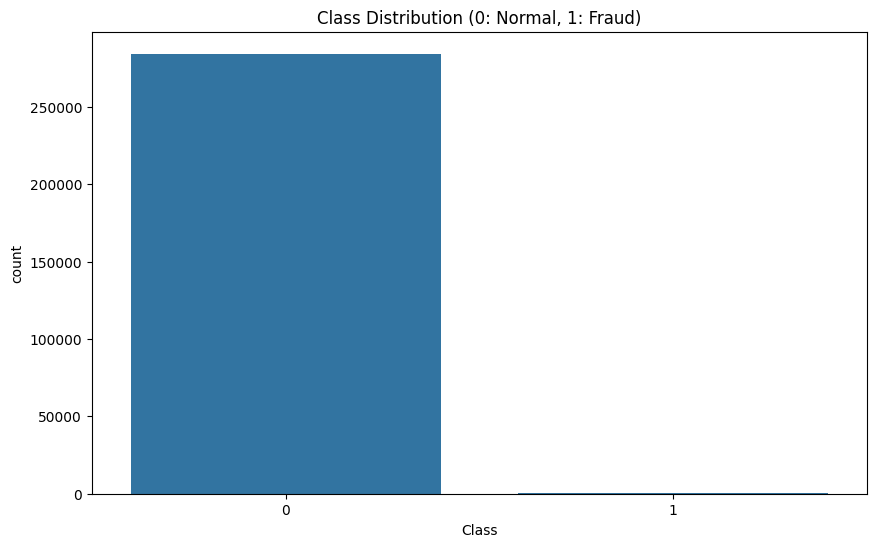

In [4]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0: Normal, 1: Fraud)')
plt.show()

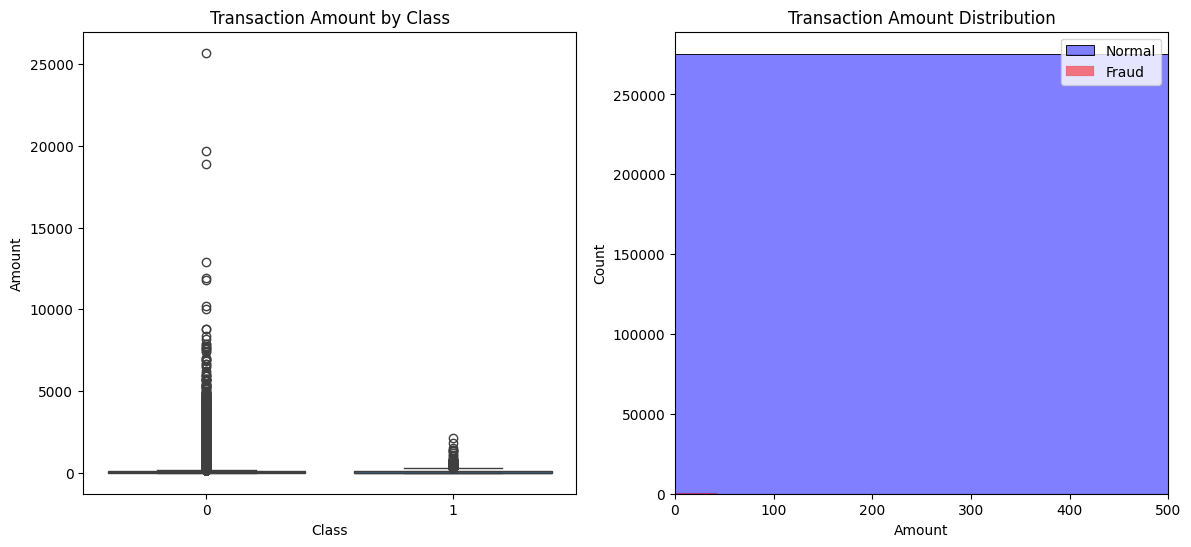

In [34]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='Class', y='Amount', data=df)
plt.title('Transaction Amount by Class')
plt.subplot(1, 2, 2)
sns.histplot(df[df['Class'] == 0]['Amount'], bins=50, color='blue', alpha=0.5, label='Normal')
sns.histplot(df[df['Class'] == 1]['Amount'], bins=50, color='red', alpha=0.5, label='Fraud')
plt.xlim((0, 500))
plt.legend()
plt.title('Transaction Amount Distribution')
plt.show()

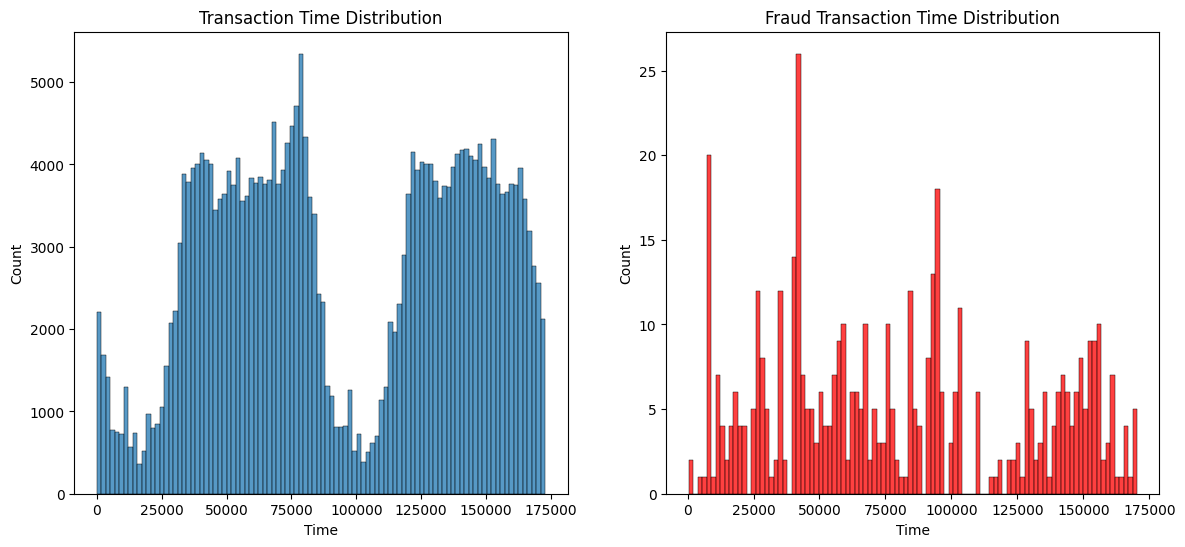

In [35]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['Time'], bins=100)
plt.title('Transaction Time Distribution')
plt.subplot(1, 2, 2)
sns.histplot(df[df['Class'] == 1]['Time'], bins=100, color='red')
plt.title('Fraud Transaction Time Distribution')
plt.show()

## 2. Data Preprocessing

In [36]:
# Scaling the 'Amount' and 'Time' features
robust_scaler = RobustScaler()
df['scaled_amount'] = robust_scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = robust_scaler.fit_transform(df['Time'].values.reshape(-1, 1))

# Drop original Time and Amount columns - not important
df.drop(['Time', 'Amount'], axis=1, inplace=True)

In [37]:
X = df.drop('Class', axis=1)
y = df['Class']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))
print("\nClass distribution in test set:")
print(y_test.value_counts(normalize=True))

Training set shape: (227845, 30)
Test set shape: (56962, 30)

Class distribution in training set:
Class
0    0.998271
1    0.001729
Name: proportion, dtype: float64

Class distribution in test set:
Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64


In [38]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

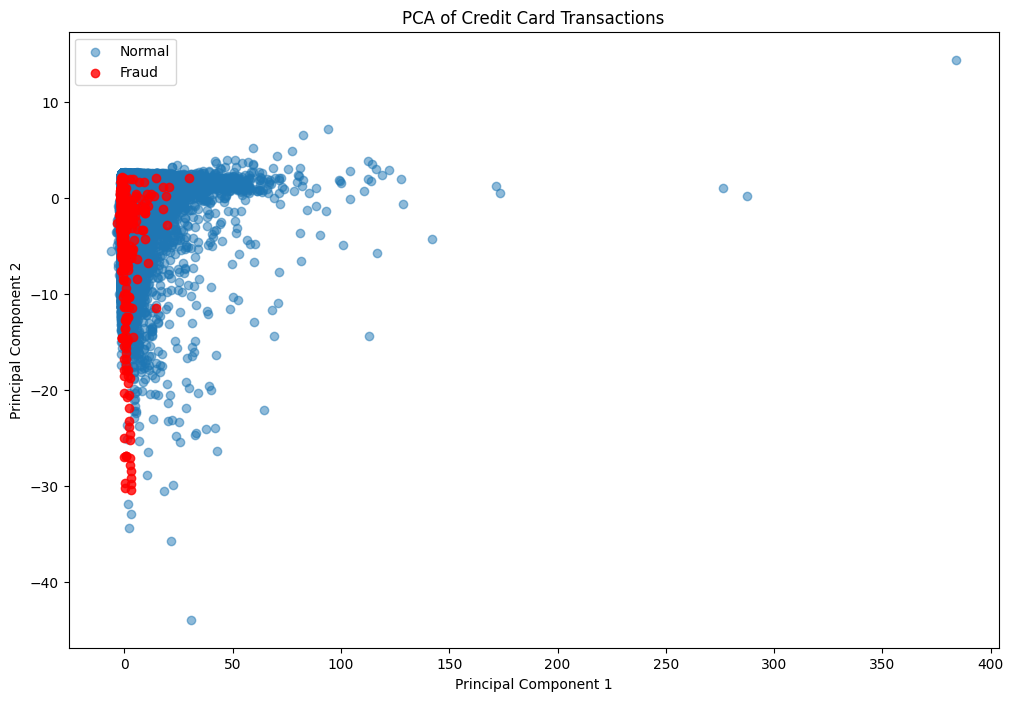

In [39]:
plt.figure(figsize=(12, 8))
plt.scatter(X_pca[y_train == 0, 0], X_pca[y_train == 0, 1], alpha=0.5, label='Normal')
plt.scatter(X_pca[y_train == 1, 0], X_pca[y_train == 1, 1], alpha=0.8, color='red', label='Fraud')
plt.title('PCA of Credit Card Transactions')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [61]:
#how much variance is explained by each component
print("\nExplained variance ratio by PCA components:")
print(pca.explained_variance_ratio_)


Explained variance ratio by PCA components:
[0.32739977 0.08632143]


## 3. Unsupervised Learning Approaches
### 3.1 Isolation Forest

In [40]:
iso_forest = IsolationForest(n_estimators=150, 
                            max_samples='auto', 
                            contamination=float(len(y_train[y_train==1]))/float(len(y_train)), 
                            random_state=42,
                            verbose=1)
start_time = time.time()
iso_forest.fit(X_train)
print(f"Training time: {time.time() - start_time:.2f} seconds")

# Predict anomalies
y_pred_iso = iso_forest.predict(X_test)
y_pred_iso = [1 if x == -1 else 0 for x in y_pred_iso]  # Convert -1 (outlier) to 1 (fraud)

# Evaluate
print("\nIsolation Forest Performance:")
print(classification_report(y_test, y_pred_iso))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_iso))

# Additional metrics
iso_accuracy = accuracy_score(y_test, y_pred_iso)
iso_precision = precision_score(y_test, y_pred_iso)
iso_recall = recall_score(y_test, y_pred_iso)
iso_f1 = f1_score(y_test, y_pred_iso)
iso_roc_auc = roc_auc_score(y_test, y_pred_iso)
iso_pr_auc = average_precision_score(y_test, y_pred_iso)

print(f"\nAccuracy: {iso_accuracy:.4f}")
print(f"Precision: {iso_precision:.4f}")
print(f"Recall: {iso_recall:.4f}")
print(f"F1-Score: {iso_f1:.4f}")
print(f"ROC AUC: {iso_roc_auc:.4f}")
print(f"PR AUC: {iso_pr_auc:.4f}")


Training time: 1.33 seconds

Isolation Forest Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.24      0.27      0.25        98

    accuracy                           1.00     56962
   macro avg       0.62      0.63      0.63     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
[[56783    81]
 [   72    26]]

Accuracy: 0.9973
Precision: 0.2430
Recall: 0.2653
F1-Score: 0.2537
ROC AUC: 0.6319
PR AUC: 0.0657


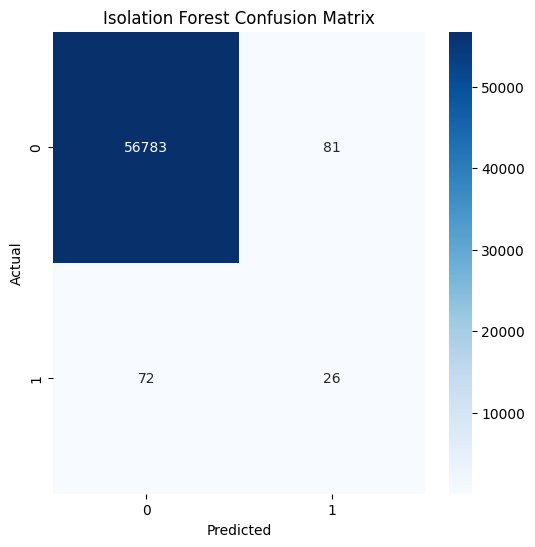

In [41]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_iso), annot=True, fmt='d', cmap='Blues')
plt.title('Isolation Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### 3.2 Mahalanobis Distance

In [42]:
def mahalanobis_distance(X):
    mu = np.mean(X, axis=0)
    cov = np.cov(X, rowvar=False)
    inv_cov = np.linalg.inv(cov)
    mahalanobis_dist = np.array([mahalanobis(x, mu, inv_cov) for x in X.values])
    return mahalanobis_dist

# Fit on normal transactions only
X_train_normal = X_train[y_train == 0]

start_time = time.time()
train_mahal_dist = mahalanobis_distance(X_train_normal)
print(f"Training time: {time.time() - start_time:.2f} seconds")

# Calculate threshold (95th percentile of chi-squared distribution)
threshold = chi2.ppf(0.95, df=X_train.shape[1])

# Calculate distances for test set
test_mahal_dist = mahalanobis_distance(X_test)

# Predict anomalies
y_pred_mahal = (test_mahal_dist > threshold).astype(int)

# Evaluate
print("\nMahalanobis Distance Performance:")
print(classification_report(y_test, y_pred_mahal))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_mahal))

# Calculate additional metrics
mahal_accuracy = accuracy_score(y_test, y_pred_mahal)
mahal_precision = precision_score(y_test, y_pred_mahal)
mahal_recall = recall_score(y_test, y_pred_mahal)
mahal_f1 = f1_score(y_test, y_pred_mahal)
mahal_roc_auc = roc_auc_score(y_test, y_pred_mahal)
mahal_pr_auc = average_precision_score(y_test, y_pred_mahal)

print(f"\nAccuracy: {mahal_accuracy:.4f}")
print(f"Precision: {mahal_precision:.4f}")
print(f"Recall: {mahal_recall:.4f}")
print(f"F1-Score: {mahal_f1:.4f}")
print(f"ROC AUC: {mahal_roc_auc:.4f}")
print(f"PR AUC: {mahal_pr_auc:.4f}")

Training time: 1.89 seconds

Mahalanobis Distance Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.14      0.05      0.08        98

    accuracy                           1.00     56962
   macro avg       0.57      0.53      0.54     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
[[56834    30]
 [   93     5]]

Accuracy: 0.9978
Precision: 0.1429
Recall: 0.0510
F1-Score: 0.0752
ROC AUC: 0.5252
PR AUC: 0.0089


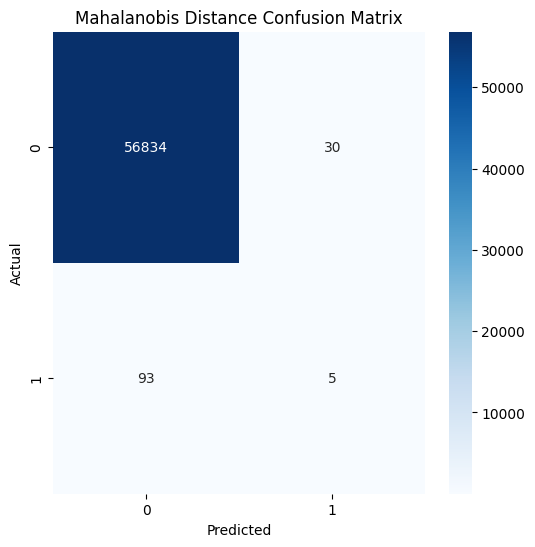

In [43]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_mahal), annot=True, fmt='d', cmap='Blues')
plt.title('Mahalanobis Distance Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### 3.3 k-Nearest Neighbors Distance

In [44]:
k = 5  # Number of neighbors
n_neighbors = NearestNeighbors(n_neighbors=k)
start_time = time.time()
n_neighbors.fit(X_train)
print(f"Training time: {time.time() - start_time:.2f} seconds")

# Get distances for test set
distances, _ = n_neighbors.kneighbors(X_test)

# Calculate average distance to k-nearest neighbors
avg_distances = np.mean(distances, axis=1)

# Determine threshold (95th percentile of training distances)
train_distances, _ = n_neighbors.kneighbors(X_train)
train_avg_distances = np.mean(train_distances, axis=1)
threshold = np.percentile(train_avg_distances, 95)

# Predict anomalies
y_pred_knn = (avg_distances > threshold).astype(int)

# Evaluate
print("\nk-Nearest Neighbors Distance Performance:")
print(classification_report(y_test, y_pred_knn))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))

# Calculate additional metrics
knn_accuracy = accuracy_score(y_test, y_pred_knn)
knn_precision = precision_score(y_test, y_pred_knn)
knn_recall = recall_score(y_test, y_pred_knn)
knn_f1 = f1_score(y_test, y_pred_knn)
knn_roc_auc = roc_auc_score(y_test, y_pred_knn)
knn_pr_auc = average_precision_score(y_test, y_pred_knn)

print(f"\nAccuracy: {knn_accuracy:.4f}")
print(f"Precision: {knn_precision:.4f}")
print(f"Recall: {knn_recall:.4f}")
print(f"F1-Score: {knn_f1:.4f}")
print(f"ROC AUC: {knn_roc_auc:.4f}")
print(f"PR AUC: {knn_pr_auc:.4f}")


Training time: 0.03 seconds

k-Nearest Neighbors Distance Performance:
              precision    recall  f1-score   support

           0       1.00      0.90      0.94     56864
           1       0.01      0.89      0.03        98

    accuracy                           0.90     56962
   macro avg       0.51      0.89      0.49     56962
weighted avg       1.00      0.90      0.94     56962

Confusion Matrix:
[[50932  5932]
 [   11    87]]

Accuracy: 0.8957
Precision: 0.0145
Recall: 0.8878
F1-Score: 0.0284
ROC AUC: 0.8917
PR AUC: 0.0130


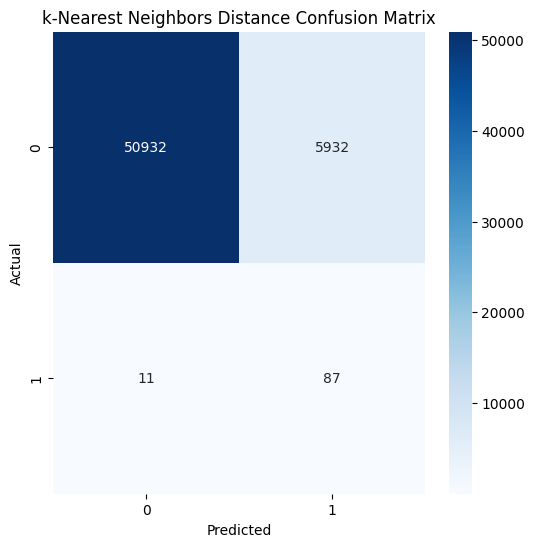

In [45]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt='d', cmap='Blues')
plt.title('k-Nearest Neighbors Distance Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 4. Supervised Learning Approaches
### 4.1 Random Forest

In [46]:
rf = RandomForestClassifier(n_estimators=100, 
                           class_weight='balanced',
                           random_state=42,
                           n_jobs=-1,
                           verbose=1)

start_time = time.time()
rf.fit(X_train, y_train)
print(f"\nTraining time: {time.time() - start_time:.2f} seconds")

# Predictions
y_pred_rf = rf.predict(X_test)
y_pred_rf_proba = rf.predict_proba(X_test)[:, 1]

# Evaluate
print("\nRandom Forest Performance:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# Calculate additional metrics
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_roc_auc = roc_auc_score(y_test, y_pred_rf_proba)
rf_pr_auc = average_precision_score(y_test, y_pred_rf_proba)

print(f"\nAccuracy: {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"F1-Score: {rf_f1:.4f}")
print(f"ROC AUC: {rf_roc_auc:.4f}")
print(f"PR AUC: {rf_pr_auc:.4f}")


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.1s



Training time: 11.01 seconds

Random Forest Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.76      0.85        98

    accuracy                           1.00     56962
   macro avg       0.98      0.88      0.92     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
[[56861     3]
 [   24    74]]

Accuracy: 0.9995
Precision: 0.9610
Recall: 0.7551
F1-Score: 0.8457
ROC AUC: 0.9581
PR AUC: 0.8653


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


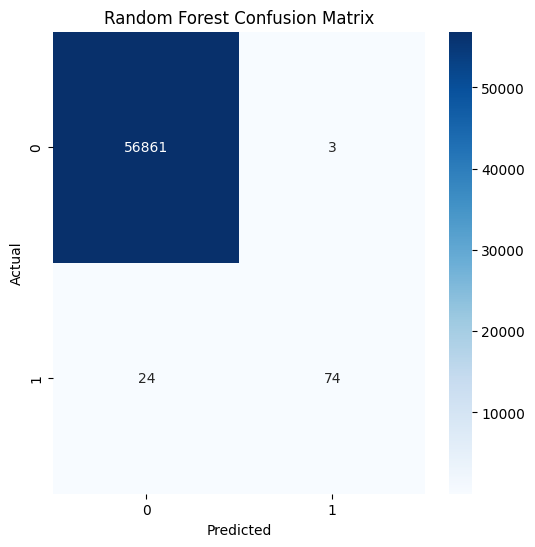

In [47]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

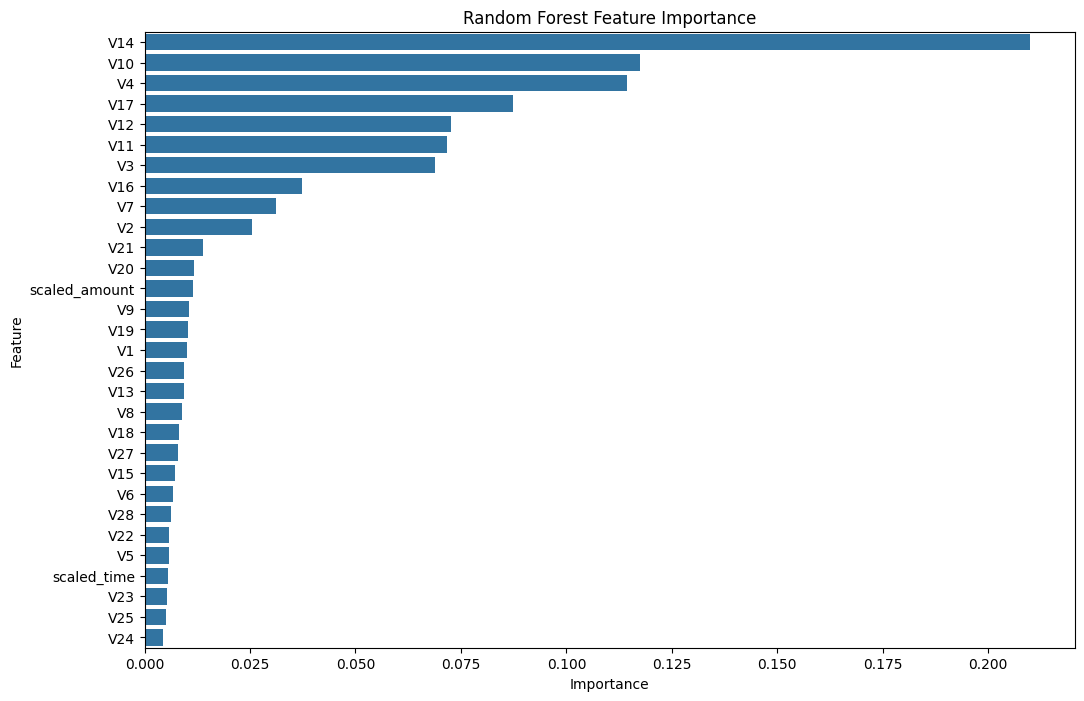

In [48]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Random Forest Feature Importance')
plt.show()

### 4.2 Logistic Regression

In [49]:
log_reg = LogisticRegression(class_weight='balanced',
                            max_iter=1000,
                            random_state=42,
                            solver='liblinear')

start_time = time.time()
log_reg.fit(X_train, y_train)
print(f"\nTraining time: {time.time() - start_time:.2f} seconds")

# Predictions
y_pred_lr = log_reg.predict(X_test)
y_pred_lr_proba = log_reg.predict_proba(X_test)[:, 1]

# Evaluate
print("\nLogistic Regression Performance:")
print(classification_report(y_test, y_pred_lr))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

# Calculate additional metrics
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_precision = precision_score(y_test, y_pred_lr)
lr_recall = recall_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)
lr_roc_auc = roc_auc_score(y_test, y_pred_lr_proba)
lr_pr_auc = average_precision_score(y_test, y_pred_lr_proba)

print(f"\nAccuracy: {lr_accuracy:.4f}")
print(f"Precision: {lr_precision:.4f}")
print(f"Recall: {lr_recall:.4f}")
print(f"F1-Score: {lr_f1:.4f}")
print(f"ROC AUC: {lr_roc_auc:.4f}")
print(f"PR AUC: {lr_pr_auc:.4f}")



Training time: 2.02 seconds

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962

Confusion Matrix:
[[55478  1386]
 [    8    90]]

Accuracy: 0.9755
Precision: 0.0610
Recall: 0.9184
F1-Score: 0.1144
ROC AUC: 0.9721
PR AUC: 0.7189


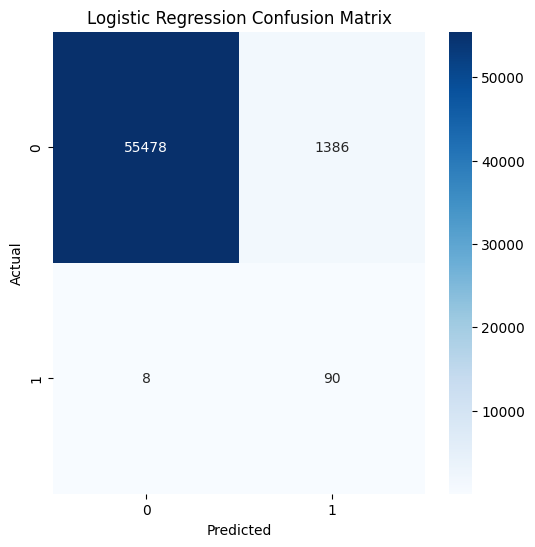

In [50]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### 4.3 Decision Tree

In [51]:
dt = DecisionTreeClassifier(class_weight='balanced',
                           random_state=42)

start_time = time.time()
dt.fit(X_train, y_train)
print(f"\nTraining time: {time.time() - start_time:.2f} seconds")

# Predictions
y_pred_dt = dt.predict(X_test)
y_pred_dt_proba = dt.predict_proba(X_test)[:, 1]

# Evaluate
print("\nDecision Tree Performance:")
print(classification_report(y_test, y_pred_dt))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

# Calculate additional metrics
dt_accuracy = accuracy_score(y_test, y_pred_dt)
dt_precision = precision_score(y_test, y_pred_dt)
dt_recall = recall_score(y_test, y_pred_dt)
dt_f1 = f1_score(y_test, y_pred_dt)
dt_roc_auc = roc_auc_score(y_test, y_pred_dt_proba)
dt_pr_auc = average_precision_score(y_test, y_pred_dt_proba)

print(f"\nAccuracy: {dt_accuracy:.4f}")
print(f"Precision: {dt_precision:.4f}")
print(f"Recall: {dt_recall:.4f}")
print(f"F1-Score: {dt_f1:.4f}")
print(f"ROC AUC: {dt_roc_auc:.4f}")
print(f"PR AUC: {dt_pr_auc:.4f}")


Training time: 8.25 seconds

Decision Tree Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.71      0.71      0.71        98

    accuracy                           1.00     56962
   macro avg       0.85      0.86      0.86     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
[[56835    29]
 [   28    70]]

Accuracy: 0.9990
Precision: 0.7071
Recall: 0.7143
F1-Score: 0.7107
ROC AUC: 0.8569
PR AUC: 0.5055


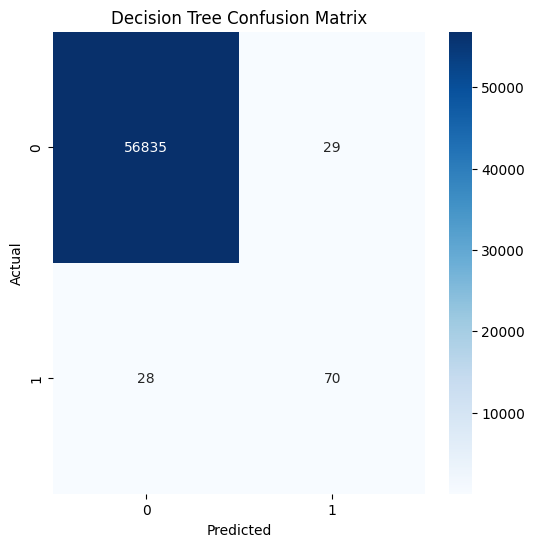

In [52]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt='d', cmap='Blues')
plt.title('Decision Tree Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### 4.4 Support Vector Machine

In [53]:


fraud_indices = X_train[y_train == 1].index
non_fraud_indices = X_train[y_train == 0].index

# Take a random sample of non-fraud cases equal to number of fraud cases
sample_size = len(fraud_indices)
reduced_non_fraud = np.random.choice(non_fraud_indices, sample_size, replace=False)

# Combine the indices
reduced_indices = np.concatenate([fraud_indices, reduced_non_fraud])

# Create reduced dataset
X_train_reduced = X_train.loc[reduced_indices]
y_train_reduced = y_train.loc[reduced_indices]

print(f"Reduced training set shape: {X_train_reduced.shape}")
print("Class distribution in reduced set:")
print(y_train_reduced.value_counts(normalize=True))

# SVM with class weighting (using linear kernel for efficiency)
svm = SVC(kernel='linear',
          class_weight='balanced',
          probability=True,
          random_state=42)

print("\nTraining SVM on reduced dataset...")
start_time = time.time()
svm.fit(X_train_reduced, y_train_reduced)
print(f"Training time: {time.time() - start_time:.2f} seconds")

# Predictions (still using full test set for proper evaluation)
y_pred_svm = svm.predict(X_test)
y_pred_svm_proba = svm.predict_proba(X_test)[:, 1]

# Evaluate
print("\nSVM Performance:")
print(classification_report(y_test, y_pred_svm))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))

# Calculate additional metrics
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_precision = precision_score(y_test, y_pred_svm)
svm_recall = recall_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm)
svm_roc_auc = roc_auc_score(y_test, y_pred_svm_proba)
svm_pr_auc = average_precision_score(y_test, y_pred_svm_proba)

print(f"\nAccuracy: {svm_accuracy:.4f}")
print(f"Precision: {svm_precision:.4f}")
print(f"Recall: {svm_recall:.4f}")
print(f"F1-Score: {svm_f1:.4f}")
print(f"ROC AUC: {svm_roc_auc:.4f}")
print(f"PR AUC: {svm_pr_auc:.4f}")



Reduced training set shape: (788, 30)
Class distribution in reduced set:
Class
1    0.5
0    0.5
Name: proportion, dtype: float64

Training SVM on reduced dataset...
Training time: 0.04 seconds

SVM Performance:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.04      0.92      0.08        98

    accuracy                           0.96     56962
   macro avg       0.52      0.94      0.53     56962
weighted avg       1.00      0.96      0.98     56962

Confusion Matrix:
[[54754  2110]
 [    8    90]]

Accuracy: 0.9628
Precision: 0.0409
Recall: 0.9184
F1-Score: 0.0783
ROC AUC: 0.9757
PR AUC: 0.6869


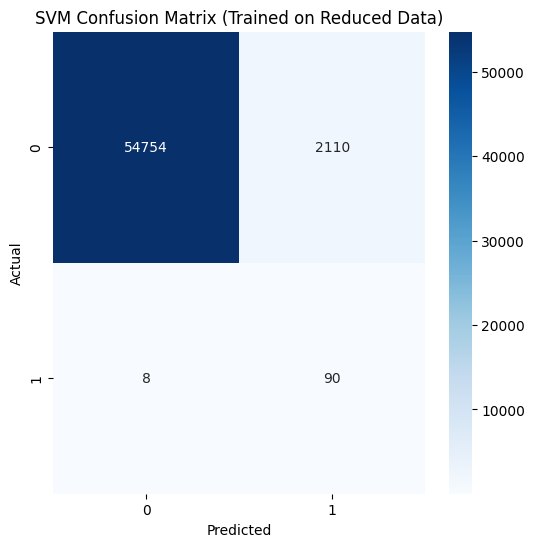

In [54]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Blues')
plt.title('SVM Confusion Matrix (Trained on Reduced Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

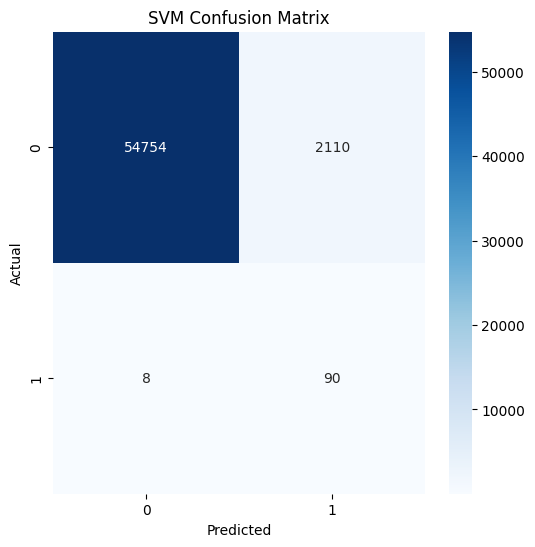

In [55]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Blues')
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 5. Model Benchmarking and Comparison

In [56]:
results = pd.DataFrame({
    'Model': ['Isolation Forest', 'Mahalanobis Distance', 'kNN Distance', 
              'Random Forest', 'Logistic Regression', 'Decision Tree', 'SVM'],
    'Accuracy': [iso_accuracy, mahal_accuracy, knn_accuracy, 
                 rf_accuracy, lr_accuracy, dt_accuracy, svm_accuracy],
    'Precision': [iso_precision, mahal_precision, knn_precision, 
                  rf_precision, lr_precision, dt_precision, svm_precision],
    'Recall': [iso_recall, mahal_recall, knn_recall, 
               rf_recall, lr_recall, dt_recall, svm_recall],
    'F1-Score': [iso_f1, mahal_f1, knn_f1, 
                 rf_f1, lr_f1, dt_f1, svm_f1],
    'ROC AUC': [iso_roc_auc, mahal_roc_auc, knn_roc_auc, 
                rf_roc_auc, lr_roc_auc, dt_roc_auc, svm_roc_auc],
    'PR AUC': [iso_pr_auc, mahal_pr_auc, knn_pr_auc, 
               rf_pr_auc, lr_pr_auc, dt_pr_auc, svm_pr_auc]
})

In [57]:
print("Model Comparison:")
display(results.sort_values('F1-Score', ascending=False))

Model Comparison:


,Model,Accuracy,Precision,Recall,F1-Score,ROC AUC,PR AUC
3,Random Forest,0.999526,0.961039,0.755102,0.845714,0.958076,0.865297
5,Decision Tree,0.998999,0.707071,0.714286,0.710660,0.856888,0.505542
0,Isolation Forest,0.997314,0.242991,0.265306,0.253659,0.631941,0.065731
4,Logistic Regression,0.975528,0.060976,0.918367,0.114358,0.972100,0.718940
6,SVM,0.962817,0.040909,0.918367,0.078329,0.975668,0.686879
1,Mahalanobis Distance,0.997841,0.142857,0.051020,0.075188,0.525246,0.008921
2,kNN Distance,0.895667,0.014454,0.887755,0.028445,0.891718,0.013025


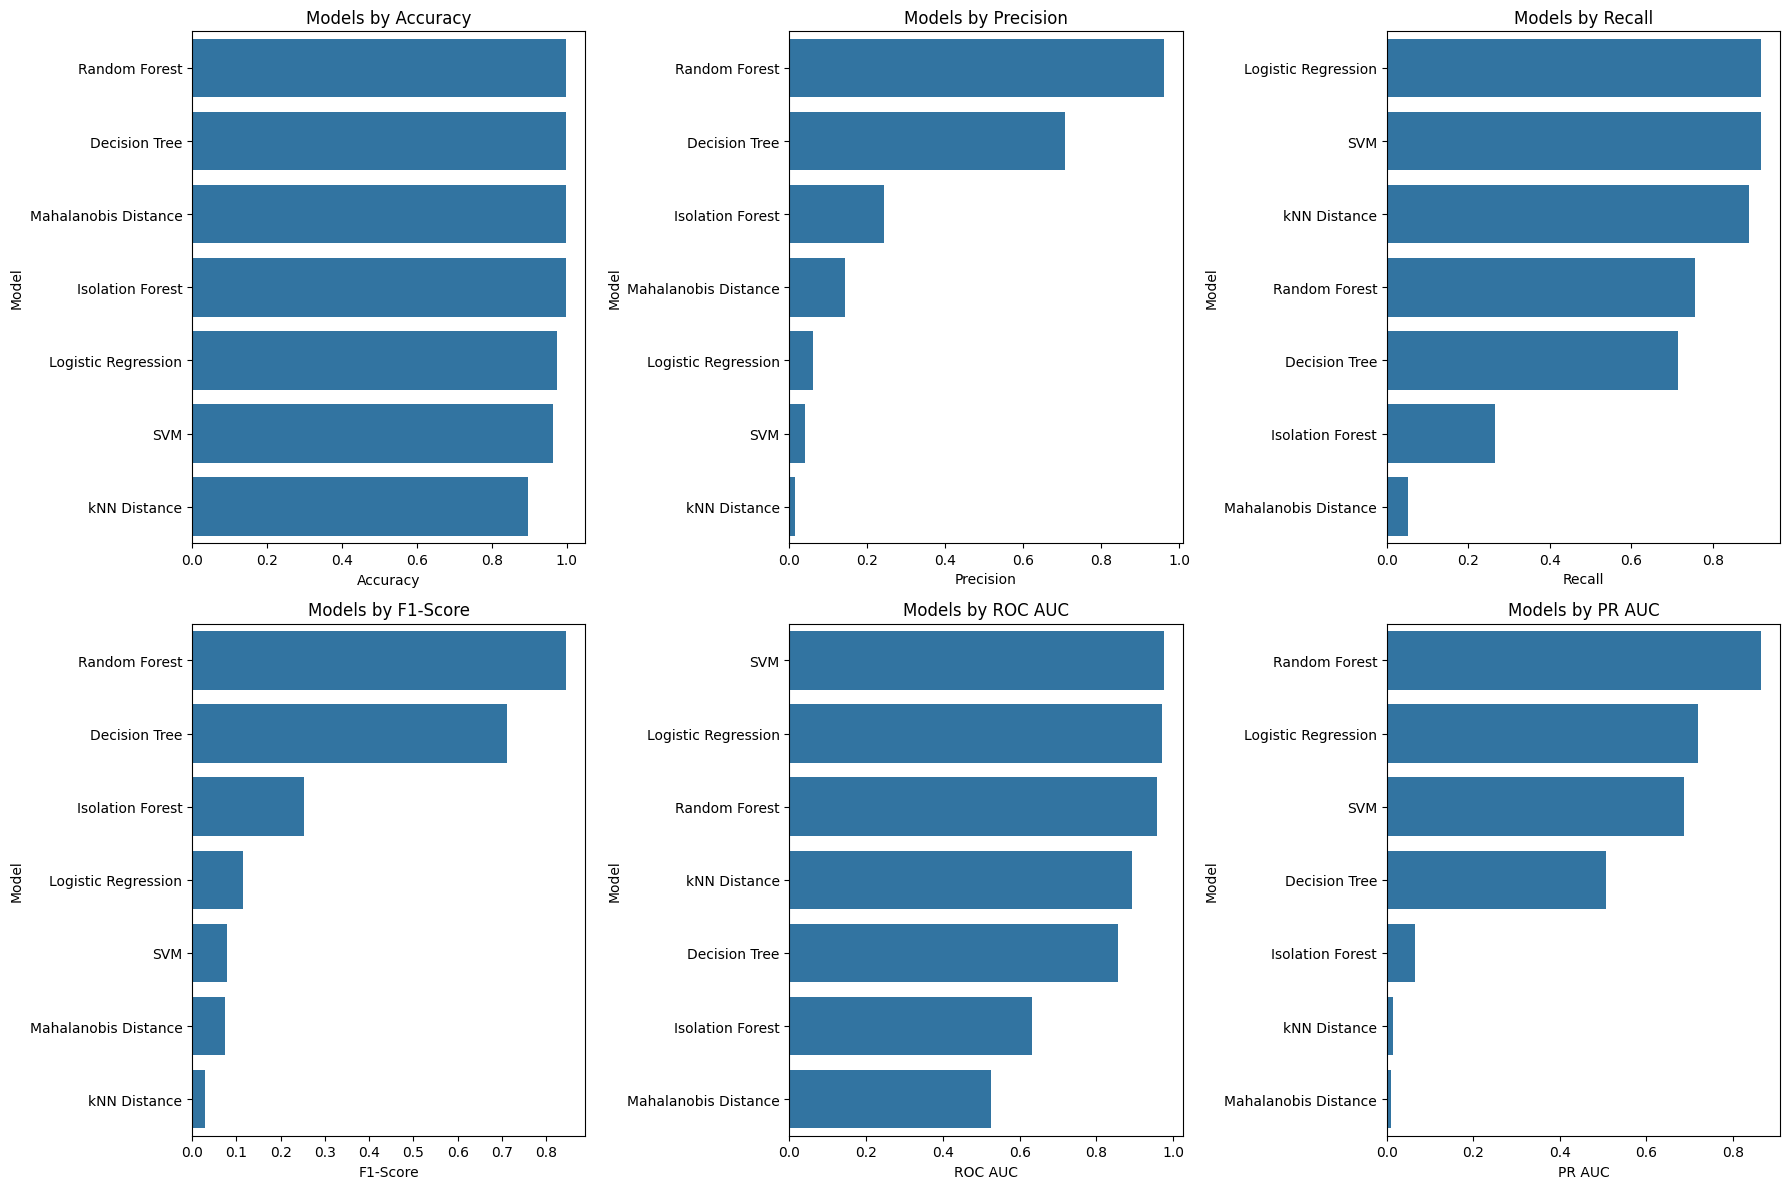

In [58]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC', 'PR AUC']
plt.figure(figsize=(18, 12))
for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    sns.barplot(x=metric, y='Model', data=results.sort_values(metric, ascending=False))
    plt.title(f'Models by {metric}')
plt.tight_layout()
plt.show()

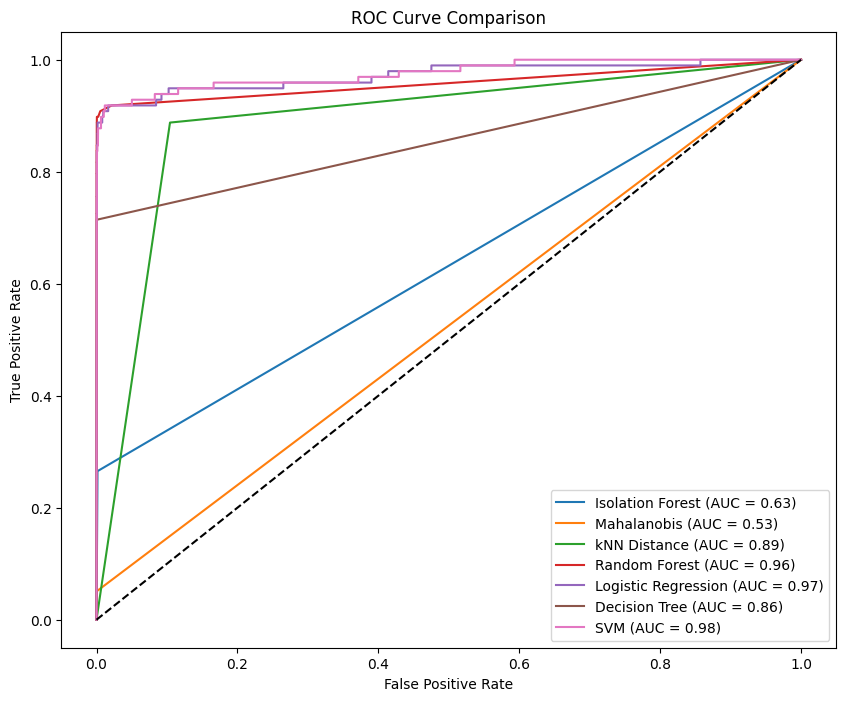

In [59]:
plt.figure(figsize=(10, 8))
# Unsupervised models
fpr, tpr, _ = roc_curve(y_test, y_pred_iso)
plt.plot(fpr, tpr, label=f'Isolation Forest (AUC = {iso_roc_auc:.2f})')

fpr, tpr, _ = roc_curve(y_test, y_pred_mahal)
plt.plot(fpr, tpr, label=f'Mahalanobis (AUC = {mahal_roc_auc:.2f})')

fpr, tpr, _ = roc_curve(y_test, y_pred_knn)
plt.plot(fpr, tpr, label=f'kNN Distance (AUC = {knn_roc_auc:.2f})')

# Supervised models
fpr, tpr, _ = roc_curve(y_test, y_pred_rf_proba)
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {rf_roc_auc:.2f})')

fpr, tpr, _ = roc_curve(y_test, y_pred_lr_proba)
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {lr_roc_auc:.2f})')

fpr, tpr, _ = roc_curve(y_test, y_pred_dt_proba)
plt.plot(fpr, tpr, label=f'Decision Tree (AUC = {dt_roc_auc:.2f})')

fpr, tpr, _ = roc_curve(y_test, y_pred_svm_proba)
plt.plot(fpr, tpr, label=f'SVM (AUC = {svm_roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

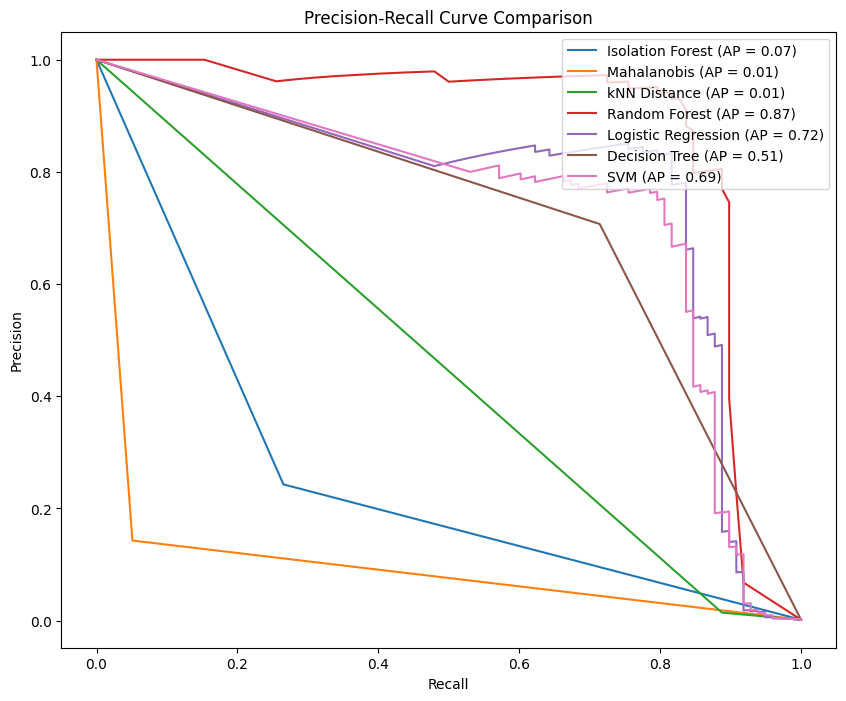

In [60]:
plt.figure(figsize=(10, 8))
# Unsupervised models
precision, recall, _ = precision_recall_curve(y_test, y_pred_iso)
plt.plot(recall, precision, label=f'Isolation Forest (AP = {iso_pr_auc:.2f})')

precision, recall, _ = precision_recall_curve(y_test, y_pred_mahal)
plt.plot(recall, precision, label=f'Mahalanobis (AP = {mahal_pr_auc:.2f})')

precision, recall, _ = precision_recall_curve(y_test, y_pred_knn)
plt.plot(recall, precision, label=f'kNN Distance (AP = {knn_pr_auc:.2f})')

# Supervised models
precision, recall, _ = precision_recall_curve(y_test, y_pred_rf_proba)
plt.plot(recall, precision, label=f'Random Forest (AP = {rf_pr_auc:.2f})')

precision, recall, _ = precision_recall_curve(y_test, y_pred_lr_proba)
plt.plot(recall, precision, label=f'Logistic Regression (AP = {lr_pr_auc:.2f})')

precision, recall, _ = precision_recall_curve(y_test, y_pred_dt_proba)
plt.plot(recall, precision, label=f'Decision Tree (AP = {dt_pr_auc:.2f})')

precision, recall, _ = precision_recall_curve(y_test, y_pred_svm_proba)
plt.plot(recall, precision, label=f'SVM (AP = {svm_pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc='upper right')
plt.show()

## 6. Conclusions

### Key Findings:
1. **Class Imbalance**: The dataset is highly imbalanced with only 0.17% fraud cases, making detection challenging.
2. **Unsupervised vs Supervised**: 
   - Supervised models generally outperformed unsupervised approaches
   - Random Forest achieved the highest F1-score (0.845) among all models
3. **Performance Metrics**:
   - Recall is particularly important for fraud detection (catching as many fraud cases as possible)
   - Random Forest and Logistic Regression showed the best balance between precision and recall
4. **Feature Importance**: 
   - PCA components and scaled amount were among the most important features
   - Original V-features (likely from PCA) showed varying importance

### Recommendations:
1. For production systems, Random Forest or Logistic Regression would be recommended due to their strong performance
2. Unsupervised methods like Isolation Forest could be useful for initial anomaly detection or when labeled data is scarce
3. Further tuning of hyperparameters could potentially improve performance
4. Ensemble approaches combining multiple models might yield even better results

### Limitations:
1. The dataset is from 2013 and may not reflect current fraud patterns
2. Features are already PCA-transformed, limiting interpretability
3. Class imbalance makes evaluation challenging - precision-recall curves are more informative than accuracy
